# Trabalho de Filtragem Colaborativa

Modelo de filtragem colaborativa usa as informações de ratings dos usuários para prover recomendações. <br>
**Ideia Principal:** A semelhança entre os usuários a partir do que se observa da interseção dos seus ratings permite inferir que os dados não inputados por apenas um destes poderia ter a mesma semelhança com relação ao outro. <br><br>
**Problemas Principais:** 
- A **esparsidade** dos dados, afinal a informação que um usuário provê é normalmente a um subconjunto muito pequeno dos itens. Logo a maioria da base de dados é de dados *faltantes* ou *não observados*. 
- **Cold-Start**: a falta de dados inicial para ter informação relevante seja para entender a personlidade de um usuário ou a preditibilidade de um item<br>
<br>
Há 2 métodos de filtragem colaborativa: <br>

**Memory-Based:** Também chamado de *neighborhood-based collaborative filtering algorithms*. Que se dividem basicamente em *user-based collaborative filtering* e *item-based collaborative filtering*. <br>
**Model-Based:** Modelos baseados em **machine learning** e **data mining** há um processo de aprendizado prévio para parametrizição. Alguns métodos são Decisions Trees, métodos bayesianos, modelos baseados em regras e latent factor method. <br>

## Implementação usando MovieLens
Carregar a base de 25M ou 100K


In [23]:
import pandas as pd                          #DataFrames e operações associadas
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity          #Similaridade
import math  
import sklearn.metrics  
from colorama import Fore, Back, Style       #prints coloridos e estilizados

ratings = pd.DataFrame()
movies = pd.DataFrame()

def carregar_base(ratings_filename, movies_filename, n_ratings = 25000000):
    global ratings
    ratings = pd.read_csv(ratings_filename)[:n_ratings] #ler as primeiras n linhas da base completa; default 25.000.000
    global movies
    movies = pd.read_csv(movies_filename).set_index("movieId")
    print(f'Arquivo {ratings_filename} carregado.')

#carregar_base('ratings.csv', 'movies.csv', n_ratings=150000)
carregar_base('ratings_small.csv', 'movies_small.csv')

#### Funções para auxiliar
def get_filmes_avaliados(usuario_):
    if(type(usuario_)==list):
        return sorted(ratings[ratings['userId'].isin(usuario_)]['movieId'].unique().tolist())
    else:
        return ratings[ratings['userId']==usuario_]['movieId'].values.tolist()

def eliminar_colunas_zeradas(matriz):
    return matriz.loc[:, (matriz != 0).any(axis=0)] #elimina todas as colunas cujos todos os valores são 0

def get_nomes_filmes(indices):
    return movies.loc[indices]['title'].values.tolist()

def get_media_avaliacao(usuario_, decimais=2):
    return round(ratings[ratings['userId'].isin([usuario_])]['rating'].mean(),decimais)

def print_destaque(texto):
    print(Back.BLUE + Fore.LIGHTYELLOW_EX+ f' {texto} ')
    print(Style.RESET_ALL)

Arquivo ratings_small.csv carregado.


In [40]:
#Pequeno relatório dos datasets originais
def print_report(ratings):
    n_ratings = len(ratings)
    n_users = len(ratings['userId'].unique())
    n_movies_avaliados = len(ratings['movieId'].unique())
    print(f"Total de ratings: {n_ratings}")
    print(f"Total de filmes: {len(movies)}")
    print(f"Filmes avaliados: {n_movies_avaliados}")
    print(f"Total de usuários: {n_users}")
    print(f"Média de ratings/user: {round(n_ratings/n_users, 2)}")
    print(f"Shape de Ratings: {ratings.shape}")
    esparsidade = round(1.0 -n_ratings/float(n_users * n_movies_avaliados),3)
    print(f"O nível de esparsidade do dataset é {esparsidade * 100}%\n")

    print_destaque('Relatório dos ratings dados pelos usuários')
    print(ratings.groupby('userId')['rating'].count().describe())

print_destaque('Relatório da base original usada')
print_report(ratings)
ratings.sample(5).sort_index()


 Relatório da base original usada 

Total de ratings: 100836
Total de filmes: 9742
Filmes avaliados: 9724
Total de usuários: 610
Média de ratings/user: 165.3
Shape de Ratings: (100836, 4)
O nível de esparsidade do dataset é 98.3%

 Relatório dos ratings dados pelos usuários 

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64


,userId,movieId,rating,timestamp
28714,199,1617,5.0,940372304
38737,266,1222,5.0,944891695
45184,298,64839,3.0,1447516912
63076,414,2289,4.0,961438151
86932,561,34319,2.0,1491091518


In [42]:
def dividir_dataset(dados, k):
    misturado = dados.sample(frac=1) #randomizar os dados   
    return np.array_split(misturado, k)  

def set_treino_teste(ratings):
    fatias = dividir_dataset(ratings, 10)
    treino = pd.concat(fatias[:-1])
    teste = fatias[-1]
    return treino, teste

ratings_treino, ratings_teste = set_treino_teste(ratings)
print_destaque('Relatório da base de treino')
print_report(ratings_treino)

 Relatório da base de treino 

Total de ratings: 90753
Total de filmes: 9742
Filmes avaliados: 9365
Total de usuários: 610
Média de ratings/user: 148.78
Shape de Ratings: (90753, 4)
O nível de esparsidade do dataset é 98.4%

 Relatório dos ratings dados pelos usuários 

count     610.000000
mean      148.775410
std       242.238996
min        16.000000
25%        32.000000
50%        63.500000
75%       153.750000
max      2422.000000
Name: rating, dtype: float64


## Gerar matriz Movies X User

In [43]:
#movies_X_users = ratings.pivot_table(index="userId", columns="movieId", values="rating", fill_value=0)
# A LINHA DE CIMA FAZ O MESMO QUE A DE BAIXO GASTANDO 15X MAIS TEMPO
moviesX_usersY = ratings_treino.groupby(['userId', 'movieId'])['rating'].first().unstack(fill_value=0.0)

#### Funções para auxiliar
def listar_filmes_ja_vistos(usuario):
    #filmes_ja_vistos_bin = matriz_filmes_X_usuarios.loc[usuario].gt(0)   #gerar array com o que usuário já deu rating: True ou False
    #return filmes_ja_vistos_bin.index[filmes_ja_vistos_bin].to_list() #com base no anterior, listar filmes que já viu        
    if(type(usuario)==list):
        filmes_usuario = moviesX_usersY.loc[usuario].sum(axis = 0)
    else: #if(type(usuario)==int):
        filmes_usuario = moviesX_usersY.loc[usuario]
    return filmes_usuario[filmes_usuario!=0].index.to_list()

def listar_filmes_nao_vistos(usuario):
    if(type(usuario)==list):
        filmes_usuario = moviesX_usersY.loc[usuario].sum(axis = 0)
    else: 
        filmes_usuario = moviesX_usersY.loc[usuario]
    return filmes_usuario[filmes_usuario==0].index.to_list()
    
def listar_notas_usuario(userId):
    return moviesX_usersY[moviesX_usersY.index==userId]

moviesX_usersY

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
titulos_users = moviesX_usersY.copy() #se não mandar uma cópia, titulo users passa ser outro nome da mesma matriz e altera ela diretamente
titulos_users.columns = movies.loc[moviesX_usersY.columns.values.tolist()].title.values.tolist()
titulos_users.head(3)

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama (2017),Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User-Based Collaborative Filtering

### Matriz de Similaridade por Usuário
A medida comumente usada é a similaridade do cosseno.
Essa medida de similaridade deve seu nome ao fato de ser igual ao cosseno do ângulo entre os dois vetores que estão sendo comparados:  vetores de similaridade de usuário (ou item) de ratings. Quanto menor o ângulo entre dois vetores, maior será o cosseno, resultando em um fator de similaridade mais alto. 

Dado 2 vetores, A e B, a similiridade por cosseno, cos($\theta$), é representada pelo produto escalar
$$\text{cosine similarity} =S_C (x,y):= \cos(\theta) = {\mathbf{x} \cdot \mathbf{y} \over \|\mathbf{x}\| \|\mathbf{y}\|} = \frac{ \sum\limits_{i=1}^{n}{x_i  y_i} }{ \sqrt{\sum\limits_{i=1}^{n}{x_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{y_i^2}} }$$

In [45]:
users_cosine_array = cosine_similarity(moviesX_usersY)
users_cosine = pd.DataFrame(data=users_cosine_array, index=moviesX_usersY.index, columns=moviesX_usersY.index)
users_cosine.round(3).head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000,0.030,0.061,0.193,0.108,0.121,0.137,0.140,0.044,0.018,...,0.081,0.152,0.218,0.065,0.147,0.141,0.254,0.259,0.074,0.136
2,0.030,1.000,0.000,0.004,0.019,0.029,0.031,0.030,0.000,0.076,...,0.222,0.019,0.013,0.000,0.000,0.026,0.015,0.044,0.031,0.098
3,0.061,0.000,1.000,0.002,0.006,0.003,0.000,0.005,0.000,0.000,...,0.005,0.005,0.025,0.000,0.011,0.014,0.019,0.014,0.000,0.034
4,0.193,0.004,0.002,1.000,0.093,0.078,0.112,0.068,0.013,0.028,...,0.078,0.119,0.280,0.047,0.079,0.191,0.102,0.143,0.024,0.107
5,0.108,0.019,0.006,0.093,1.000,0.258,0.097,0.428,0.000,0.017,...,0.077,0.399,0.094,0.250,0.096,0.089,0.144,0.114,0.275,0.051


### Selecionar a similaridade desejada

Nota: se fazer média das notas primeiro e usar cosseno, obtem-se mesmos valores que dá fazendo pearson diretamente. 
```python
    movies_X_users = movies_X_users - np.asarray([(np.mean(movies_X_users, 1))]).T
```
Implementação a seguir de **Pearson** não é recomendada pois gasta esta biblioteca é menos otimizada gastando cerca de 5x da implementação acima de cosseno 

$$r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$

```python
    users_pearson = movies_X_users.T.corr(method='pearson') #pode usar tb kendall e spearman
```

### Pegar os k usuários mais similares ao Target selecionado
<center><img src="img/user-based-similaridades.jpg" ></center>

Como selecionar os mais similares?
- Todos os vizinhos
- Selecionar randomicamente
- Todos acima de um threshold
- Top-k por simaridade

Problemas
- Custo computacional
- Mais vizinhos = mais ruído
- Poucos vizinhos = pouca cobertura
- Usar entre 25 e 100

In [46]:
def obter_mais_similares(target, matriz_similaridade, k = 25, min_score = 0):
    similares = matriz_similaridade.loc[target].sort_values(ascending=False).drop(target)
    similares = similares[similares >= min_score]
    return similares.iloc[:k]

### Matriz de filmes não vistos pelo usuário target e que receberam notas dos usuários mais similares

In [23]:
target = 1
usuarios_mais_similares = obter_mais_similares(1, users_cosine, 25).index
#gerar matriz dos usuarios mais similares x filmes não assistidos ainda pelo usuário
usuarios_similares_X_filmes_nao_vistos = moviesX_usersY.loc[usuarios_mais_similares].drop(columns=listar_filmes_ja_vistos(1)) 
usuarios_similares_X_filmes_nao_vistos = eliminar_colunas_zeradas(usuarios_similares_X_filmes_nao_vistos)
print('Matriz de filmes não vistos por usuários mais similares:',usuarios_similares_X_filmes_nao_vistos.shape)
usuarios_similares_X_filmes_nao_vistos.head(8)

Matriz de filmes não vistos por usuários mais similares: (25, 2862)


movieId,2,5,7,9,10,11,12,13,15,16,...,146656,148626,149406,152081,160438,164179,165101,166528,166643,168174
userId,,,,,,,,,,,,,,,,,,,,,
266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,3.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
469,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288,2.0,2.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Gerar a Recomendação de acordo com a nota dada pelos usuários similares

Podemos usar várias métricas de acordo com os ratings dos vizinhos: mínimo, máximo, média, mediana, média ponderada, agregação supervisionada.
<br>
Usaremos **média ponderada** logo:
1. Para cada filme que se deseja saber a nota: 
2. Para cada usuário similar da lista:
    1. Se nota foi dada: somar nota seguindo a fórmula
$$ notaMédia = {\sum coeficiente * nota \over \sum coeficiente} $$
<center><img src="img/user-based-similaridades2.jpg" ></center>

In [24]:
def predizer_notas_userb_mediap(target, filmes, matriz_similaridade = users_cosine, matriz_dados = moviesX_usersY, k=25, min_threshold=0): 
                                            # min_threshold: qtd mínima de notas para ser considerada ao recomendar um filme
    similares = obter_mais_similares(target, matriz_similaridade, 25)

    resultado = pd.DataFrame(columns=filmes, index=['User Pred', '# Notas'] ) 
    resultado.columns.name = 'movieId'
    for filme in filmes:
        numerador = 0
        denominador = 0
        qtd_notas = 0
        for similar in similares.index:
            nota = matriz_dados.loc[similar,filme]
            if (nota != 0):
                coeficiente = similares[similar]
                numerador += nota * coeficiente
                denominador += coeficiente
                qtd_notas += 1
        if (qtd_notas < min_threshold):
            resultado = resultado.drop([filme], axis=1) #se a qt de notas for menor que limiar, descartar coluna com informação daquele filme
        else: #se não, prencher a nota calculada da média ponderada e a qtd de notas dadas
            try:
                resultado.at['User Pred',filme] = round(numerador/denominador,1)
            except:
                #print(f"filme:{filme}, numerador:{numerador}, denominador: {denominador}, qt. notas: {qtd_notas}.")
                resultado.at['User Pred',filme] = 0
            resultado.at['# Notas',filme] = qtd_notas
    return resultado

In [25]:
qtd_sugestoes = 20 #qtd de sugestões para exibir na tela

filmes_vistos_pelo_usuario = listar_filmes_ja_vistos(target) 
filmes_vistos_pelos_similares = listar_filmes_ja_vistos(usuarios_mais_similares.values.tolist())
filmes_a_avaliar = list(set(filmes_vistos_pelos_similares)-set(filmes_vistos_pelo_usuario))
recomendacao = predizer_notas_userb_mediap(target, filmes_a_avaliar, users_cosine, moviesX_usersY, 25, 5)
#recomendacao
recomendacao.T.sort_values(by=['User Pred','# Notas',],ascending=False).head(qtd_sugestoes).join(movies[['title']], on=["movieId"])


,User Pred,# Notas,title
movieId,,,
750,4.7,9,Dr. Strangelove or: How I Learned to Stop Worr...
1203,4.7,7,12 Angry Men (1957)
953,4.7,6,It's a Wonderful Life (1946)
858,4.6,19,"Godfather, The (1972)"
1221,4.5,17,"Godfather: Part II, The (1974)"
318,4.5,14,"Shawshank Redemption, The (1994)"
1193,4.5,13,One Flew Over the Cuckoo's Nest (1975)
778,4.5,10,Trainspotting (1996)
1199,4.5,9,Brazil (1985)


#### Nota por *Mean-Centered* (trad: média centralizada?)
$$ notaPredita_u = \mu_u + {\sum coeficiente * (nota-\mu_v) \over \sum coeficiente} $$

In [46]:
def predizer_notas_userb_meanc(target, filmes, matriz_similaridade = users_cosine, matriz_dados = moviesX_usersY, k=25, min_threshold=0): 
                                            # min_threshold: qtd mínima de notas para ser considerada ao recomendar um filme
    similares = obter_mais_similares(target, matriz_similaridade, 25)

    resultado = pd.DataFrame(columns=filmes, index=['User Pred2', '# Notas.'] ) 
    resultado.columns.name = 'movieId'
    media_target = get_media_avaliacao(target)
    for filme in filmes:
        numerador = 0
        denominador = 0
        qtd_notas = 0
        for similar in similares.index:
            nota = matriz_dados.loc[similar,filme]
            if (nota != 0):
                coeficiente = similares[similar]
                numerador += coeficiente * (nota - get_media_avaliacao(similar))
                denominador += coeficiente
                qtd_notas += 1
        if (qtd_notas < min_threshold):
            resultado = resultado.drop([filme], axis=1) #se a qt de notas for menor que limiar, descartar coluna com informação daquele filme
        else: #se não, prencher a nota calculada da média ponderada e a qtd de notas dadas
            try:
                resultado.at['User Pred2',filme] = media_target + round(numerador/denominador,1)
            except:
                #print(f"filme:{filme}, numerador:{numerador}, denominador: {denominador}, qt. notas: {qtd_notas}.")
                resultado.at['User Pred2',filme] = 0
            resultado.at['# Notas.',filme] = qtd_notas
    return resultado

In [47]:
qtd_sugestoes = 20 #qtd de sugestões para exibir na tela

filmes_vistos_pelo_usuario = listar_filmes_ja_vistos(target) 
filmes_vistos_pelos_similares = listar_filmes_ja_vistos(usuarios_mais_similares.values.tolist())
filmes_a_avaliar = list(set(filmes_vistos_pelos_similares)-set(filmes_vistos_pelo_usuario))
recomendacao = predizer_notas_userb_meanc(target, filmes_a_avaliar, users_cosine, moviesX_usersY, 25, 5)
#recomendacao
recomendacao.T.sort_values(by=['User Pred2','# Notas.',],ascending=False).head(qtd_sugestoes).join(movies[['title']], on=["movieId"])

,User Pred2,# Notas.,title
movieId,,,
750,5.67,9,Dr. Strangelove or: How I Learned to Stop Worr...
953,5.67,6,It's a Wonderful Life (1946)
1203,5.57,7,12 Angry Men (1957)
858,5.47,19,"Godfather, The (1972)"
1193,5.47,13,One Flew Over the Cuckoo's Nest (1975)
1199,5.47,9,Brazil (1985)
1221,5.37,17,"Godfather: Part II, The (1974)"
318,5.37,14,"Shawshank Redemption, The (1994)"
1653,5.37,13,Gattaca (1997)


## Avaliando a eficácia do método
1. Selecionar um target randômico
2. Selecionar alguns valores de notas dadas por ele
3. Tentar predizer sua nota com base nos seus similares, 


In [50]:
rnd_user = pd.DataFrame()
rnd_user = moviesX_usersY.sample()
rnd_user = eliminar_colunas_zeradas(rnd_user)
rnd_user_id = rnd_user.index.values[0]
prd_rnd_userA = predizer_notas_userb_mediap(rnd_user_id, rnd_user.columns, users_cosine, moviesX_usersY, 25, 0)
prd_rnd_userB = predizer_notas_userb_meanc(rnd_user_id, rnd_user.columns, users_cosine, moviesX_usersY, 25, 0)
userb= pd.concat([pd.concat([rnd_user,prd_rnd_userA]),prd_rnd_userB])
userb.drop("# Notas",axis=0,inplace=True)
userb

movieId,7,356,594,830,898,899,904,906,913,914,...,2795,2858,2918,2941,2967,3061,3097,3341,3469,5060
188,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4.0,3.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0
User Pred,2.5,4.1,3.9,2.7,4.4,4.5,4.8,4.5,4.3,4.3,...,3.7,4.3,4.0,3.6,4.0,4.3,4.0,4.2,3.5,4.1
User Pred2,3.2,4.9,4.8,3.5,5.2,5.2,5.5,5.5,5.0,5.2,...,4.3,5.0,4.7,4.8,4.9,5.3,5.0,4.9,4.2,5.1
# Notas.,5,14,10,4,16,16,13,2,15,13,...,6,17,15,6,2,5,1,5,3,10


4. Calcular margem de erro 

Uma medida frequentemente usada na verificação da acurácia de modelos numéricos é o Erro Quadrático Médio (MSE na sigla em Inglês) como descrito, por exemplo, em Wilks (2006).MSE é sempre positivo. MSE = 0 indica simulação perfeita. MSE é definido por:
$$ MSE = \frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2 $$

Em adição ao MSE, a raiz quadrada de MSE, ou Raiz do Erro Quadrático Médio (RMSE em Inglês), é comumente usada para expressar a acurácia dos resultados numéricos com a vantagem de que RMSE apresenta valores do erro nas mesmas dimensões da variável analisada. O RMSE é definido por:
$$ RMSE = \sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2} $$

In [52]:
def calcular_rmse(real, previsao):
    mse = sklearn.metrics.mean_squared_error(real, previsao)     
    #mse = np.square(np.subtract(notasReais,notasPreditas)).mean()      
    #print("Erro Quadrático Médio (MSE):", mse)         
    return math.sqrt(mse)  

def testar_predicao_user_based(userId, printar_notas=False):
    notas_reais = moviesX_usersY[moviesX_usersY.index==userId]
    notas_reais = eliminar_colunas_zeradas(notas_reais)
    filmes_assistidos = notas_reais.columns
    notas_preditas = predizer_notas_userb_mediap(userId, filmes_assistidos, users_cosine, moviesX_usersY,25,0)
    notas_reais = notas_reais.values.tolist()[0]
    notas_preditas = notas_preditas.loc["User Pred"].values.tolist()
    if(printar_notas):
        print(notas_reais)
        print(notas_preditas)
    return calcular_rmse(notas_reais,notas_preditas)

def testar_predicao_user_based2(userId, printar_notas=False):
    notas_reais = moviesX_usersY[moviesX_usersY.index==userId]
    notas_reais = eliminar_colunas_zeradas(notas_reais)
    filmes_assistidos = notas_reais.columns
    notas_preditas = predizer_notas_userb_meanc(userId, filmes_assistidos, users_cosine, moviesX_usersY,25,0)
    notas_reais = notas_reais.values.tolist()[0]
    notas_preditas = notas_preditas.loc["User Pred2"].values.tolist()
    if(printar_notas):
        print(notas_reais)
        print(notas_preditas)
    return calcular_rmse(notas_reais,notas_preditas)

print("Raiz do Erro Quadrático Médio (média ponderada):", testar_predicao_user_based(402))
print("Raiz do Erro Quadrático Médio (mean centered):", testar_predicao_user_based2(402))
    

Raiz do Erro Quadrático Médio (média ponderada): 1.4723139384429305
Raiz do Erro Quadrático Médio (mean centered): 1.425


In [80]:
usuarios = moviesX_usersY.index.to_list()
estatistica_user_based = pd.DataFrame(index = usuarios)
for i in usuarios:
    estatistica_user_based.at[i,"rmse_User"]=testar_predicao_user_based(i)
estatistica_user_based['rmse_User'].std()
estatistica_user_based.describe()

,rmse_User
count,610.000000
mean,1.332527
std,0.409591
min,0.554076
25%,1.055818
50%,1.272814
75%,1.534406
max,3.209090


<AxesSubplot:>

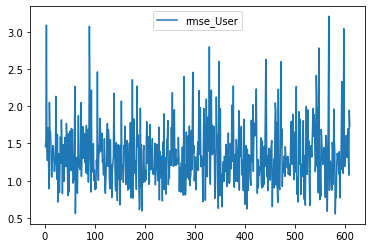

In [81]:
estatistica_user_based.plot()

In [79]:
import random

usuarios = moviesX_usersY.index.to_list()
estatistica_user_based = pd.DataFrame(index = usuarios)
for i in random.sample(usuarios,10):
    estatistica_user_based.at[i,"rmse_User"]=testar_predicao_user_based2(i)
estatistica_user_based['rmse_User'].std()
estatistica_user_based.describe()

,rmse_User
count,10.000000
mean,1.120974
std,0.295456
min,0.789573
25%,0.865164
50%,1.060667
75%,1.388596
max,1.544816


---
---

## Item-Based Collaborative Filtering

### Gerar matriz Users X Movies
Transposição da matriz que tinha usuários nas linhas e filmes nas colunas, para filmes nas linhas e usuários nas colunas

In [57]:
usersX_moviesY = moviesX_usersY.T
usersX_moviesY.head(4)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Matriz de Similaridade Item a Item
Similaridade por Cosseno dos filmes entre si

In [58]:
movies_cosine_array = cosine_similarity(usersX_moviesY)
movies_cosine = pd.DataFrame(data=movies_cosine_array, index=usersX_moviesY.index, columns=usersX_moviesY.index)
movies_cosine.head()
#movies_pearson = movies_users.corr(method='pearson')

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Selecionar um usuário e analisar os filmes que ele não deu nota
Os targets serão os filmes que o usuário não deu nota. É analisado os k filmes mais similares ao que ele não viu, e destes, de acordo com as notas que o usuário deu, é calculado a nota estimada. Isto é feito para todos os filmes.

<center><img src="img/item-based-cosseno-predicao.jpg" style="max-width: 50%"></center>

1. pegar um usuário e os filmes que ele não assistiu
2. pegar um filme que ele não assistiu e selecionar os K mais semelhantes & que o usuário deu nota
3. fazer a média ponderada entre as notas que ele deu pra estes filmes semelhantes para definir a nota nova faltante

In [201]:
def predizer_notas2(usuario, filmes, matriz_similaridade=movies_cosine, matriz_dados = usersX_moviesY, k=25, min_threshold=3):
    usuario = 1
    filmes_não_avaliados = listar_filmes_nao_vistos(usuario) #O que essa essa matriz dados???

    #recomendacao = pd.DataFrame(columns=("movieId", "Nota", "Qt de Notas"))
    resultado = pd.DataFrame(columns=filmes, index=['Item Pred', '# Notas'] ) 
    resultado.columns.name = 'movieId'

    set_avaliados = set(get_filmes_avaliados(usuario))

    for filme in filmes:  #Para cada filme que desejamos a predição, obterei aqueles mais similares
        filmes_mais_similares = obter_mais_similares(filme, matriz_similaridade, k, 0.2)
        similares_vistos = list(set(filmes_mais_similares.index) & set_avaliados) #e ver quais que já foram avaliados
        numerador = 0
        denominador = 0
        qtd_notas = 0
        for i in similares_vistos: #para cada filme similar avaliado, calcular a média ponderada
            coeficiente = matriz_similaridade[filme][i]
            nota = usersX_moviesY[usuario][i] 
            if (nota != 0):
                numerador += nota * coeficiente
                denominador += coeficiente
                qtd_notas += 1  
        if(qtd_notas < min_threshold):
            resultado = resultado.drop([filme], axis=1) #se a qt de notas for menor que limiar, descartar coluna com informação daquele filme
        else: #se não, prencher a nota calculada da média ponderada e a qtd de notas dadas
            try:
                resultado.at['Item Pred',filme] = round(numerador/denominador,1)
            except:
                #print(f"filme:{filme}, numerador:{numerador}, denominador: {denominador}, qt. notas: {qtd_notas}.")
                resultado.at['Item Pred',filme] = 0
            resultado.at['# Notas',filme] = qtd_notas
            #recomendacao.loc[len(recomendacao)] = [int(filme), round(numerador/denominador,2), qtd_notas]
    return resultado


filmes_não_avaliados = listar_filmes_nao_vistos(1)
recomendacao = predizer_notas2(1, filmes_não_avaliados[:15000],movies_cosine,usersX_moviesY,).T.join(movies[['title']], on=["movieId"]).sort_values(by=['Item Pred','# Notas','title'],ascending=False)
recomendacao.head(20)

,Item Pred,# Notas,title
movieId,,,
4011,5.0,9,Snatch (2000)
1234,5.0,7,"Sting, The (1973)"
4262,5.0,6,Scarface (1983)
4226,5.0,6,Memento (2000)
7153,5.0,6,"Lord of the Rings: The Return of the King, The..."
4993,5.0,6,"Lord of the Rings: The Fellowship of the Ring,..."
1947,5.0,5,West Side Story (1961)
3254,5.0,5,Wayne's World 2 (1993)
1125,5.0,5,"Return of the Pink Panther, The (1975)"


In [202]:
filmes_ja_avaliados = get_filmes_avaliados(1)
filmes_considerados = pd.DataFrame()
for filme in filmes_ja_avaliados:
    filmes_considerados = pd.concat([filmes_considerados,obter_mais_similares(filme, movies_cosine, 25, 0.4)])
filmes_considerados = filmes_considerados.sort_values(by=0, ascending=False)
filmes_considerados = filmes_considerados.index.to_list()
filmes_considerados = list(set(filmes_considerados)-set(filmes_ja_avaliados))
recomendacao2 = predizer_notas2(1, filmes_considerados[:15000],movies_cosine,usersX_moviesY,).T.join(movies[['title']], on=["movieId"]).sort_values(by=['Item Pred','# Notas','title'],ascending=False)
recomendacao2.head(20)

,Item Pred,# Notas,title
movieId,,,
4011,5.0,9,Snatch (2000)
1234,5.0,7,"Sting, The (1973)"
4262,5.0,6,Scarface (1983)
4226,5.0,6,Memento (2000)
7153,5.0,6,"Lord of the Rings: The Return of the King, The..."
4993,5.0,6,"Lord of the Rings: The Fellowship of the Ring,..."
1947,5.0,5,West Side Story (1961)
3254,5.0,5,Wayne's World 2 (1993)
4973,5.0,5,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ..."


In [197]:
rnd_user = pd.DataFrame()
rnd_user = moviesX_usersY.sample()
rnd_user = eliminar_colunas_zeradas(rnd_user)
rnd_user_id = rnd_user.index.values[0]
prd_rnd_user = predizer_notas_userb_mediap(rnd_user_id, rnd_user.columns, users_cosine, moviesX_usersY, 25, 0)
prd_rnd_user2 = predizer_notas2(rnd_user_id, rnd_user.columns, movies_cosine, usersX_moviesY, 50, 0)
pd.concat([rnd_user,prd_rnd_user,prd_rnd_user2])

movieId,1,10,19,22,34,39,47,48,60,110,...,586,587,588,589,590,592,593,595,597,736
584,5.0,5.0,3.0,4.0,3.0,1.0,5.0,5.0,5.0,5.0,...,4.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0,3.0,5.0
User Pred,4.6,3.3,2.9,3.3,4.2,3.5,3.9,3.5,3.3,4.6,...,3.3,4.0,3.9,3.9,3.9,3.4,4.3,4.0,3.4,3.7
# Notas,7,15,10,3,15,13,13,8,3,18,...,13,20,21,21,22,23,17,18,20,8
Item Pred,4.3,3.9,4.3,4.3,4.1,4.0,4.5,4.4,4.2,4.2,...,4.2,3.8,3.9,4.2,4.0,4.1,4.5,4.0,3.8,4.0
# Notas,30,22,17,9,18,16,28,11,4,27,...,21,15,20,32,17,21,31,17,13,19


In [198]:
def testar_predicao_item_based(userId, printar_notas=False):
    notas_reais = moviesX_usersY[moviesX_usersY.index==userId]
    notas_reais = eliminar_colunas_zeradas(notas_reais)
    filmes_assistidos = notas_reais.columns
    notas_preditas = predizer_notas2(userId, filmes_assistidos, movies_cosine, usersX_moviesY,25,0)
    notas_reais = notas_reais.values.tolist()[0]
    notas_preditas = notas_preditas.loc["Item Pred"].values.tolist()
    if(printar_notas):
        print(notas_reais)
        print(notas_preditas)
    return math.sqrt(sklearn.metrics.mean_squared_error(notas_reais, notas_preditas))

print("Raiz do Erro Quadrático Médio :", testar_predicao_item_based(3))


Raiz do Erro Quadrático Médio : 3.3331666624997918


In [199]:
estatistica_item_based = pd.DataFrame(index = usuarios)
for i in usuarios:
    estatistica_item_based.at[i,"rmse_Item"]=testar_predicao_item_based(i)
estatistica_item_based['rmse_Item'].std()
pd.merge(estatistica_user_based.describe(), estatistica_item_based.describe(), left_index=True, right_index=True,)

,rmse_User,rmse_Item
count,610.000000,610.000000
mean,1.332527,2.263674
std,0.409591,0.673851
min,0.554076,0.734361
25%,1.055818,1.790865
50%,1.272814,2.274315
75%,1.534406,2.722546
max,3.209090,4.168404


## Outra abordagem de item based (não faz parte da proposta do trabalho)

In [63]:
usuarioId_target = 1
usuario = moviesX_usersY.loc[usuarioId_target].sort_values(ascending=False)
rate_mais_alto = usuario.iloc[0]
filmes_mais_gosta = usuario[usuario >= rate_mais_alto].index.tolist()
assistiu_n_filmes = len(usuario[usuario > 0].index.to_list())
print(f"O usuário {usuarioId_target} assistiu {assistiu_n_filmes} filmes e deu nota {rate_mais_alto} para estes {len(filmes_mais_gosta)} filmes: ")


O usuário 1 assistiu 232 filmes e deu nota 5.0 para estes 124 filmes: 


### Similaridade dos filmes favoritos com os filmes não assistidos
Matriz onde cada um dos filmes favoritos é um índice e cada coluna é um filme que não foram assistidos ainda.

In [64]:
lista_filmes_ja_vistos = listar_filmes_ja_vistos(usuarioId_target)
print(f"Usuario {usuarioId_target} já assistiu {len(lista_filmes_ja_vistos)} filmes.")
filmes_pro_usuario = movies_cosine.loc[filmes_mais_gosta].drop(columns=lista_filmes_ja_vistos)
filmes_pro_usuario = eliminar_colunas_zeradas(filmes_pro_usuario) #eliminar as colunas dos filmes que não similaridade nenhuma com nada
filmes_pro_usuario

Usuario 1 já assistiu 232 filmes.


movieId,2,4,5,7,8,9,10,11,12,13,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
2991,0.148219,0.000000,0.126004,0.045809,0.057514,0.054039,0.292736,0.136541,0.219055,0.049193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1220,0.301501,0.054021,0.138388,0.151197,0.067566,0.011203,0.306229,0.243034,0.097315,0.117648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1282,0.268140,0.020001,0.203573,0.197865,0.121510,0.016118,0.188510,0.235216,0.110627,0.196821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,0.355192,0.030574,0.179859,0.130588,0.072232,0.029656,0.263267,0.176428,0.071878,0.084399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2899,0.040948,0.000000,0.000000,0.000000,0.000000,0.116505,0.061309,0.000000,0.143113,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,0.379890,0.043835,0.151397,0.164152,0.067499,0.051514,0.396171,0.229860,0.153564,0.121005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2353,0.294842,0.000000,0.042770,0.082134,0.088108,0.040906,0.268768,0.196302,0.132080,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,0.085195,0.000000,0.016860,0.030874,0.000000,0.000000,0.026092,0.065416,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transformamos a matriz numa 1xN filmes com o valor máximo encontra de similaridade; e ordenamos essa matriz, selecionando os k filmes com maior similaridade apresentada <br>
Feito também um **join** com movies para mostrar o título

In [65]:
k = 20
#pegar a similaridade máxima que cada um dos filmes não vistos possui com os filmes já vistos
recomendacao = filmes_pro_usuario.max().sort_values(ascending=False).head(k)
recomendacao = pd.DataFrame(recomendacao).join(movies['title'], on='movieId')
recomendacao

,0,title
movieId,,
2683,0.751857,Austin Powers: The Spy Who Shagged Me (1999)
3633,0.724992,On Her Majesty's Secret Service (1969)
5083,0.707107,Rare Birds (2001)
3747,0.707107,Jesus' Son (1999)
2607,0.706998,Get Real (1998)
5347,0.706018,Deuces Wild (2002)
5425,0.704664,Dark Blue World (Tmavomodrý svet) (2001)
5486,0.700000,Who Is Cletis Tout? (2001)
3078,0.700000,Liberty Heights (1999)


In [66]:
recomendacao = recomendacao.rename(columns={'title': 'Recomendação', 0: 'Score'})
pq_vc_assistiu = []
nota_media = []
for id in recomendacao.index:
    pq_vc_assistiu.append(filmes_pro_usuario.index[filmes_pro_usuario[id] == recomendacao.loc[id][0]].tolist()[0])
    nota_media.append(ratings.groupby(['movieId'])['rating'].mean().loc[id])
recomendacao['Nota média'] = nota_media
recomendacao['Pq vc assistiu'] = get\_nomes_filmes(pq_vc_assistiu)
recomendacao

,Score,Recomendação,Nota média,Pq vc assistiu
movieId,,,,
2683,0.751857,Austin Powers: The Spy Who Shagged Me (1999),3.198347,Austin Powers: International Man of Mystery (1...
3633,0.724992,On Her Majesty's Secret Service (1969),3.264706,Thunderball (1965)
5083,0.707107,Rare Birds (2001),3.500000,Shaft (1971)
3747,0.707107,Jesus' Son (1999),3.500000,Shaft (1971)
2607,0.706998,Get Real (1998),4.000000,Shaft (1971)
5347,0.706018,Deuces Wild (2002),2.500000,Shaft (1971)
5425,0.704664,Dark Blue World (Tmavomodrý svet) (2001),4.250000,Shaft (1971)
5486,0.700000,Who Is Cletis Tout? (2001),2.500000,Shaft (1971)
3078,0.700000,Liberty Heights (1999),4.000000,Shaft (1971)


---
---

# SVD: Fatoração de Matriz
Devido a esparsidade do dataset, os métodos tradicionais de filtragem colaborativa podem não serem adequados a demanda de processamento. Uma forma de tratar é fazendo uso do algoritmo de **Singular Value Decomposition**, SVD.<br>
Neste algoritmo, a matriz é decomposta em  em outras 3 matrizes de menor dimensionalidade.
$$ A = USV^T$$
- A é a matriz original m x n
- U é uma matriz ortogonal m x n (mesmo shape de A)
- S é uma matriz diagonal n x n (valores $\sigma_1 \geqslant \sigma_2 \geqslant ... \geqslant \sigma_n$ => ordenados por importância)
- V é uma matriz ortogonal n x n

https://www.researchgate.net/publication/330136513_Building_a_Movie_Recommendation_System_using_SVD_algorithm

https://heartbeat.comet.ml/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

http://alyssaq.github.io/2015/20150426-simple-movie-recommender-using-svd/

https://www.kaggle.com/code/cast42/simple-svd-movie-recommender

https://csiu.github.io/blog/update/2017/04/18/day53.html

Bom PDF para ler sobre fatoração de matrizes:
https://www.maxwell.vrac.puc-rio.br/19273/19273_4.PDF

In [277]:
from scipy.sparse.linalg import svds
from numpy import count_nonzero
U, sigma, Vt = svds(moviesX_usersY.to_numpy(), k = 10) #o que são essas k features

print(f"Matriz original{moviesX_usersY.shape} decomposta em U{U.shape}, sigma {sigma.shape} e Vt{Vt.shape}.")

sigma_diag_matrix=np.diag(sigma) #sigma é um array contendo a diagonal
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)
matriz_SVD = pd.DataFrame(all_user_predicted_ratings, columns = moviesX_usersY.columns, index=moviesX_usersY.index)

esparsidade_SVD = 1.0 - ( count_nonzero(matriz_SVD) / float(matriz_SVD.size) )
print("Esparsidade: ", esparsidade_SVD,"%")

matriz_SVD.head()

Matriz original(610, 9724) decomposta em U(610, 10), sigma (10,) e Vt(10, 9724).
Esparsidade:  0.0 %


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.861726,0.937778,0.975957,-0.017830,0.216177,1.702736,0.105428,0.000205,0.146076,1.997412,...,-0.012587,-0.010789,-0.014386,-0.014386,-0.012587,-0.014386,-0.012587,-0.012587,-0.012587,-0.019309
2,0.192522,-0.008264,-0.026998,0.003019,0.025943,0.086721,-0.056641,0.012829,-0.012171,-0.078800,...,0.005953,0.005103,0.006803,0.006803,0.005953,0.006803,0.005953,0.005953,0.005953,0.013188
3,0.031622,0.016571,0.019504,-0.004169,-0.015130,0.078697,-0.013183,0.000482,0.007625,0.063260,...,0.000239,0.000205,0.000273,0.000273,0.000239,0.000273,0.000239,0.000239,0.000239,-0.001889
4,1.574333,0.233673,0.278655,0.056570,0.187347,0.267250,0.328903,-0.054729,-0.018870,0.078537,...,-0.001781,-0.001527,-0.002036,-0.002036,-0.001781,-0.002036,-0.001781,-0.001781,-0.001781,-0.010068
5,1.277728,0.976974,0.422940,0.126277,0.537362,0.751711,0.630211,0.116558,0.117054,1.154697,...,0.000582,0.000499,0.000665,0.000665,0.000582,0.000665,0.000582,0.000582,0.000582,-0.000066


In [278]:
def testar_predicao_SVD(userId, printar_notas=False):
    notas_reais = moviesX_usersY[moviesX_usersY.index==userId]
    notas_reais = eliminar_colunas_zeradas(notas_reais)
    filmes_assistidos = notas_reais.columns
    notas_preditas = matriz_SVD[matriz_SVD.index==userId][filmes_assistidos]
    notas_reais = notas_reais.values.tolist()[0]
    notas_preditas = notas_preditas.values.tolist()[0]
    if(printar_notas):
        print(notas_reais)
        print(notas_preditas)
    return math.sqrt(sklearn.metrics.mean_squared_error(notas_reais, notas_preditas))

In [292]:
estatistica_SVD = pd.DataFrame(index = usuarios)
for i in usuarios:
    estatistica_SVD.at[i,"rmse_SVD"]=testar_predicao_SVD(i)
estatistica_SVD['rmse_SVD'].describe()
#pd.merge(estatistica_user_based.describe(), estatistica_item_based.describe(), left_index=True, right_index=True,)

count    610.000000
mean       2.997130
std        0.628125
min        0.870686
25%        2.547759
50%        3.066764
75%        3.447550
max        4.961767
Name: rmse_SVD, dtype: float64

In [286]:
estatistica_SVD['rmse_SVD'].std()

0.6320116962221388

In [298]:
dados_do_SVD = pd.DataFrame()
for r in range(1,30):
    k = r*5
    U, sigma, Vt = svds(moviesX_usersY.to_numpy(), k ) #o que são essas k features

    sigma_diag_matrix=np.diag(sigma) #sigma é um array contendo a diagonal
    all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)
    matriz_SVD = pd.DataFrame(all_user_predicted_ratings, columns = moviesX_usersY.columns, index=moviesX_usersY.index)

    for i in usuarios:
        estatistica_SVD.at[i,'rmse_SVD']=testar_predicao_SVD(i)
    dp = estatistica_SVD['rmse_SVD'].std()
    print(k, ": ", dp)
    #dados_do_SVD.concat([r,dp])
    #dados_do_SVD.at[i] = estatistica_SVD['rmse_SVD'].std()
    #dados_do_SVD = pd.merge(dados_do_SVD, estatistica_SVD.describe(), left_index=True, right_index=True,)

#dados_do_SVD

5 :  0.5935545846837844
10 :  0.6320116962221389
15 :  0.6549003426587992
20 :  0.677607031737377
25 :  0.6914823343136309
30 :  0.7112759495178654
35 :  0.7304640369118949
40 :  0.7460425279736048
45 :  0.7611835366268828
50 :  0.7769561335205206
55 :  0.7925902729742547
60 :  0.8071133525278414
65 :  0.8194576292017971
70 :  0.8321580093951625
75 :  0.842762385046984
80 :  0.8544159111048617
85 :  0.8649921516739925
90 :  0.8764957939634447
95 :  0.886035617069391
100 :  0.8950161458611524
105 :  0.9015433032305508
110 :  0.9086900873753875
115 :  0.9160600423800445
120 :  0.9225156737447514
125 :  0.9287809004071581
130 :  0.9335728984682884
135 :  0.9389268513165727
140 :  0.9430686702753261
145 :  0.9454801183514994


In [263]:
testar_predicao_SVD(1)

3.070575958820681

In [309]:
def predizer_notas3(userId):
    filmes_não_vistos = listar_filmes_nao_vistos(userId)
    recomendação = matriz_SVD[matriz_SVD.index==userId][filmes_não_vistos]
    recomendação.drop(columns= recomendação[recomendação<0].columns)
    return recomendação

predizer_notas3(1)

movieId,2,4,5,7,8,9,10,11,12,13,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.472394,0.089944,0.23467,0.298102,-0.036421,-0.209432,0.020422,0.471189,-0.043272,-0.153334,...,0.032753,0.028074,0.037432,0.037432,0.032753,0.037432,0.032753,0.032753,0.032753,-0.00861


In [225]:
user = 1

rec_ = pd.DataFrame(index=list(rec), columns=['Título', 'Nota'])
rec_.index.name='movieId'
rec_['Título'] = get\_nomes_filmes(rec)
for id in rec:
    rec_.at[id,'Nota'] = matriz_SVD.loc[user,id]
rec_



,Título,Nota
movieId,,
480,Jurassic Park (1993),4.074629
296,Pulp Fiction (1994),4.854252
1036,Die Hard (1988),4.009045
2028,Saving Private Ryan (1998),5.465609
593,"Silence of the Lambs, The (1991)",4.269116
733,"Rock, The (1996)",4.005126


In [223]:
recomendacao2

,Item Pred,# Notas,title
movieId,,,
4011,5.0,9,Snatch (2000)
1234,5.0,7,"Sting, The (1973)"
4262,5.0,6,Scarface (1983)
4226,5.0,6,Memento (2000)
7153,5.0,6,"Lord of the Rings: The Return of the King, The..."
...,...,...,...
2160,3.5,5,Rosemary's Baby (1968)
1717,3.5,3,Scream 2 (1997)
112,3.4,5,Rumble in the Bronx (Hont faan kui) (1995)


https://colab.research.google.com/drive/1GYSJNXK6lRl8kb2FvtMPLqW8EuZLcJjN?usp=sharing#scrollTo=NwjVPkZPctFU

# Copiar as explicações e gráficos